# The Yield Curve and Discount Rates


## FINM 37400: Fixed Income

### Mark Hendricks

#### Winter 2025

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
FutureWarning


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from scheffer_quant.fixed_income.fi_pricing import *
from scheffer_quant.fixed_income.treasury import *
from scheffer_quant.fixed_income.curve_construction import *
from scheffer_quant.fixed_income.fi_cash_flows import *

In [2]:
QUOTE_DATE = '2024-05-31'
TYPE_PROCESSING = 'crsp'

filepath_rawdata = f'../data/treasury_quotes_{TYPE_PROCESSING}_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')

if TYPE_PROCESSING=='crsp':
    treasuries = process_wrds_treasury_data(rawdata)
    treasuries['clean price'] = treasuries['price'].copy()
    treasuries['price'] = treasuries['dirty price'].copy()
    treasuries.drop(columns=['dirty price'])

else:
    treasuries = rawdata

In [3]:
treasuries

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,clean price
KYTREASNO,,,,,,,,,,,,,,
208166,bill,2024-05-31,2024-02-06,2024-06-04,0.010951,0.978097,0.000,99.942167,99.942278,99.942222,0.000000,99.942222,0.053476,99.942222
208141,bill,2024-05-31,2023-12-07,2024-06-06,0.016427,0.967146,0.000,99.912583,99.912750,99.912667,0.000000,99.912667,0.053901,99.912667
208179,bill,2024-05-31,2024-02-13,2024-06-11,0.030116,0.939767,0.000,99.839278,99.839583,99.839431,0.000000,99.839431,0.054077,99.839431
208072,bill,2024-05-31,2023-06-15,2024-06-13,0.035592,0.928816,0.000,99.810417,99.810778,99.810597,0.000000,99.810597,0.053981,99.810597
207730,note,2024-05-31,2021-06-15,2024-06-15,0.041068,0.918033,0.250,99.804688,99.812500,99.923348,0.114754,99.923348,0.049698,99.808594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208107,bond,2024-05-31,2023-08-15,2053-08-15,29.207392,0.582418,4.125,91.457031,91.519531,92.689518,1.201236,92.689518,0.046611,91.488281
208149,bond,2024-05-31,2023-11-15,2053-11-15,29.459274,0.086957,4.750,101.605469,101.667969,101.843240,0.206522,101.843240,0.046470,101.636719
208178,bond,2024-05-31,2024-02-15,2054-02-15,29.711157,0.582418,4.250,93.511719,93.574219,94.780606,1.237637,94.780606,0.046527,93.542969


# Yield-to-Maturity (YTM)

The **yield-to-maturity** is the internal rate of return on the cash flows—the uniform interest rate such that when the future cash flows are discounted at that rate, the sum of the present values equals the price of the bond. It is the implied market discount rate.

The yield-to-maturity is the rate of return on the bond to an investor given three **critical assumptions**:

1. The investor holds the bond to maturity.
2. The issuer makes all of the coupon and principal payments in the full amount on the scheduled dates. Therefore, the yield-to-maturity is the promised yield—the yield assuming the issuer does not default on any of the payments.
3. The investor is able to reinvest coupon payments at that same yield. This is a characteristic of an internal rate of return.


- The yield-to-maturity provides a poor estimate of expected return if interest rates are volatile, the yield curve is steeply sloped upward or downward, there is significant risk of default, or the bond has embedded options.
    - It does not capture the effect of reinvesting coupons at new rates due to changes in the shape of the yield curve. Recall that to realize the initial yield-to-maturity requires that coupons be reinvested as implied by the initial yield-to-maturity.
- If the yield curve remains flat during the holding period, the realized rate of return on a bond will be the same as the expected rate of return.


# The Spot Curve and No-Arbitrage

Above we saw that
1. YTM is an alternate way to quote a price
2. For a zero-coupon bond held to maturity, it is the annualized return.

Beyond that, YTM is not useful.

**In particular, YTM is not useful for pricing other securities.**

* YTM assigns a discount rate to the security (across all its cashflows) 
* We seek a discount rate that fits a particular maturity, for use across all securities paying at that maturity.

A more fundamental approach to calculate the price of a bond is to use a sequence of market discount rates that correspond to the cash flow dates. These market discount rates are called **spot rates**.

## Spot Rates

- Spot rates are yields-to-maturity on zero-coupon bonds maturing at the date of each cash flow. Sometimes these are called “zero rates.
-  Bond price (or value) determined using the spot rates is sometimes referred to as the bond’s **“no-arbitrage value.”**

- The value of a bond calculated by discounting its future cash flows by their corresponding spot rates will be the same as the value obtained by discounting future cash flows by the yield-to-maturity of a bond, only if the yield-to-maturity is some weighted average of the spot rates used to value the bond.

## No arbitrage

- No-arbitrage conditions say that two risk-free cashflows occuring at the same time must have the same price.
- Thus, any arbitrage-free pricing must tie the discount to the cashflow timing, not to its originating security.
- For this reason, the YTM will not work for pricing. Instead, we use the **spot curve**.


## The Spot Curve
The goverment bond **spot curve**, sometimes called the **zero or “strip” curve** (because the coupon payments are “stripped” off of the bonds) or **yield curve** (though not to be confused with observed YTM!).

The spot, zero, or strip curve is a sequence of yields-to-maturity on zero- coupon bonds. Often, these government spot rates are interpreted as the “risk-free” yields; in this context, “risk-free” refers only to default risk. There still could be a significant amount of inflation risk to the investor, as well as liquidity risk.

The spot curve represents the term structure of interest rates.

 The spot curve shows, for various maturities, the annualized return on an option-free and default-risk-free zero-coupon bond (zero for short) with a single payment at maturity. For this reason, spot rates are also referred to as zero- coupon yields or zero rates. The spot rate as a yield concept avoids the need for a reinvestment rate assumption for coupon- paying securities.

We seek a **spot curve** of discount rates, $r(t,T)$ such that we can price cashflows as,

Again, let $P_j(t,T,c)$ denote the price of 
- bond $j$ 
- observed time-$t$ 
- which matures at time $T$ 
- with coupons occuring at interim cashflow dates $T_i$ for $1\le i <n$
- and a final coupon and principal payment occuring at maturity $T$.

Then the **spot curve** rates, $r(t,T)$ would price the bond as,

$
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{r(t,T_i)}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{r(t,T)}{2}\right)^{2(T-t)}}
$

Note:
- Divide and multiply by 2 because the coupons are assumed to be semi-annually
- At the end, we have (1+c/2) because of the principal

Note that this equation **differs** from the YTM definitional equation. 
* The spot rate, $r(t,T_i)$ does not depend on the specific bond, $j$. It can price any security that has a cash flow in that time period.
* It is a function of the cashflow timing, $T_i$.

### Reminder: YTM Formula

Define the **yield-to-maturity** for bond $j$ as the term $y_j$ which satisfies the following equation:

$
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T-t)}}
$

Note that the same rate, $y_j$, is discounting cashflows at different maturities.
* It is unique to the security, $j$.
* It is constant across the security's various cashflow maturities.

Thus it is not useful for pricing different securities. It only works if used the YTM that comes from that security. 

***

# The Discount Curve

## Discount Factor vs Compounded Rates
Note that all the compounded rates will imply the same discount, when the compounding frequency is accounted for.

$\displaystyle\text{discount} \equiv \; Z(t,T) = \frac{1}{\left(1+\frac{r_n}{n}\right)^{n(T-t)}} \; = e^{-r(T-t)}$


**The discount factors are uniquely determined and can be converted to a spot curve of any compounding frequency.**

### Example
Consider, as an example, the annually compounded spot rate of 5\% at a maturity of $T-t=1$.

In [4]:
rate = .05
compound_base = 1

ngrid = [1, 2, 4, 12, 52, 365]
compounded_rate = pd.DataFrame(index=ngrid,columns=['rate','discount'],dtype=float)
for n in ngrid:
    compounded_rate.loc[n] = compound_rate(int_rate=rate,
                                           compound_input=compound_base,
                                           compound_output=n)
    compounded_rate.loc[n,'discount'] = 1/(1+compounded_rate.loc[n,'rate']/n)**n
    
compounded_rate.loc['continuous','rate'] = compound_rate(int_rate=rate,
                                                         compound_input=compound_base,
                                                         compound_output=None)

compounded_rate.loc['continuous','discount'] = convert_rate_to_discount(rate_or_discount=compounded_rate.loc['continuous','rate'],
                                                                        time_to_maturity=compound_base,n_compound=None)

display(compounded_rate.style.format("{:.4%}"))

,rate,discount
1,5.0000%,95.2381%
2,4.9390%,95.2381%
4,4.9089%,95.2381%
12,4.8889%,95.2381%
52,4.8813%,95.2381%
365,4.8793%,95.2381%
continuous,4.8790%,95.2381%


## The Curve

Denote the discount curve as $Z(t,T)$.

* This value depends on the maturity.
* It is not compounded. Any compounded spot rate will lead to this discount.

The discount curve is useful for multiplicative pricing.

### Zero Coupon Bond

$
\begin{align}
P_j(t,T) = Z(t,T) \times 100
\end{align}
$

### Coupon Bond

$\displaystyle P_j(t,T,c) = \sum_{i=1}^{n-1} 100 Z(t,T_i)\frac{c}{2} + 100 Z(t,T)\left(1+\frac{c}{2}\right)$

#### Use
If we estimate the discount curve (equivalent to estimating the spot curve) then we can apply these discount factors to price other fixed-income securities.
Analysts usually use only the most recently issued and actively traded government bonds to build a yield curve.

***

# Modeling the Spot Curve

## Filter Data

Filter to eliminate...
* maturities that are too short or long
* quotes that do not have a quoted positive yield
* TIPS (because we are building a curve to price nominal cash flows)
    * Keep only TIPS if want a curve to price real cash flows

Filter dates to eliminate...
* dates where no bond is maturing (identification)
* dates that are not benchmark treasury dates (liquidity)

## Map Cashflows

In [5]:
rawdata.set_index('KYTREASNO',inplace=True)

CF = calc_treasury_cashflows(quote_data=rawdata)
prices = treasuries['price'][CF.index]

CFset = {'all dates, including negative YTM quotes':CF}
display(CF)

,2024-06-04,2024-06-06,2024-06-11,2024-06-13,2024-06-15,2024-06-18,2024-06-20,2024-06-25,2024-06-27,2024-06-30,...,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
204083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Estimating the discounts

Consider the following notation
* $\boldsymbol{p}$: $n\times 1$ vector of the price for each issue
* $\boldsymbol{z}$: $k\times 1$ vector of the discounts for each cash-flow time
* $\boldsymbol{C}$: $n\times k$ matrix of the cashflow for each issue (row) and each time (column)

$$\boldsymbol{p} = \boldsymbol{C}\boldsymbol{z}$$

If we allow for estimation error and small market frictions:

$$\boldsymbol{p} = \boldsymbol{C}\boldsymbol{z}+\epsilon$$

Note:
- If there are multiple treasuries maturing in the same date, we need to choose one to build a discount curve, or perhaps do a regression to get the best fitting rate.
    - We cannot estimate $p$ exactly, so we have $\epsilon$.

### Which estimation?

What if $\boldsymbol{C}$ is
* square: $n=k$
* tall: $n>k$
* wide: $k>n$

### Identified

Suppose $\boldsymbol{C}$ is linearly **independent**.

*What does this mean?*

If $n=k$, 
* perfectly identified system of equations
* no need for error, $\epsilon$
* **solve** with linear system of equations

If $n>k$,
* overidentified
* include $\epsilon$
* **estimate** with regression

### Unidentified

In this case,
* discount curve is not identified
* pseuodoinverse?
* LASSO?

# Perfect Estimation of Spot Curve

## Bootstrap

- In case when we have a perfect system

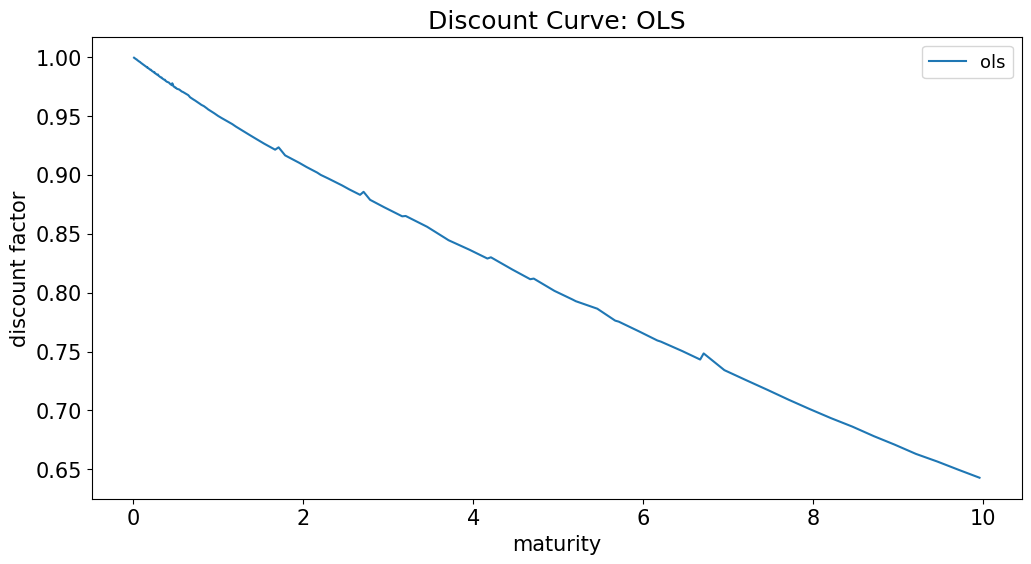

In [6]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

model_name = 'bootstrap'

date_curr = treasuries['quote date'].iloc[0]

filtered_treasuries = filter_treasuries(data=rawdata,
                         date_curr=date_curr,
                         filter_yld = RESTRICT_YLD,
                         filter_tips = RESTRICT_TIPS,
                         drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_treasury_cashflows(quote_data=filtered_treasuries),
                               filter_maturity_dates=RESTRICT_DTS_MATURING)
label = 'single maturity per date, no non-maturity dates'
CFset[label] = CF

prices = treasuries['price'][CF.index]
params_boot = estimate_rate_curve(model_name=model_name,
                                  cf=CF,
                                  prices=prices,
                                  date_curr=date_curr)

disc_boot = pd.DataFrame({'maturity':params_boot[0], 'ols': params_boot[1]}).set_index('maturity')
disc_boot.plot(ylabel='discount factor',title='Discount Curve: OLS')
plt.show()


## OLS Estimation

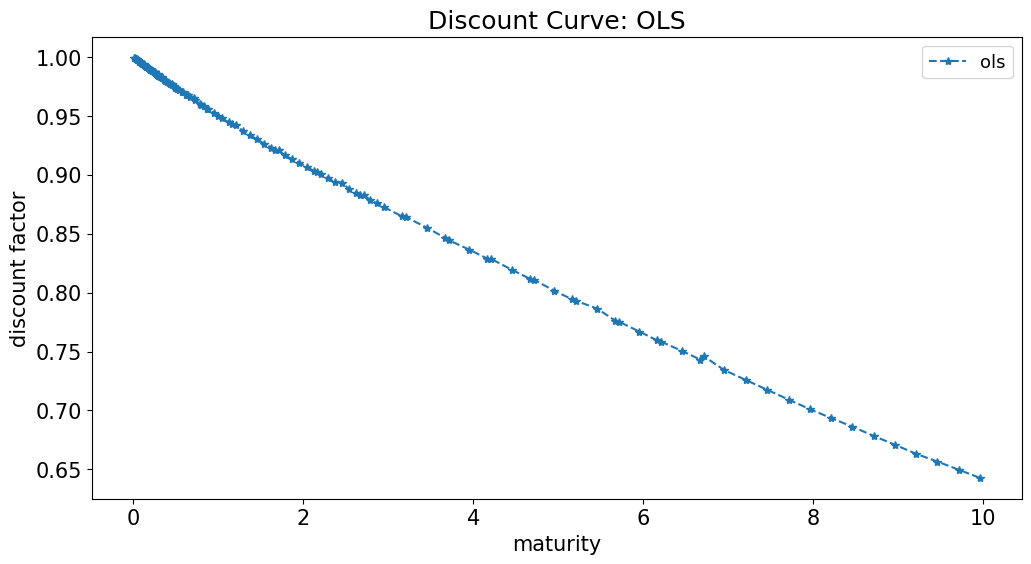

In [7]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False # For OLS, we want to keep all the data

model_name = 'ols'

date_curr = treasuries['quote date'].iloc[0]

filtered_treasuries = filter_treasuries(data=rawdata,
                         date_curr=date_curr,
                         filter_yld = RESTRICT_YLD,
                         filter_tips = RESTRICT_TIPS,
                         drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_treasury_cashflows(quote_data=filtered_treasuries),
                               filter_maturity_dates=RESTRICT_DTS_MATURING)
label ='no non-maturity dates'
CFset[label] = CF

prices = treasuries['price'][CF.index]
params_OLS = estimate_rate_curve(model_name=model_name,
                                  cf=CF,
                                  prices=prices,
                                  date_curr=date_curr)

disc_ols = pd.DataFrame({'maturity':params_OLS[0], 'ols': params_OLS[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

## Spot Curve

Recall that the **spot curve of interest rates** can be calculated for any **compounding frequency**. 

The figure below plots it for **continuous compounding**.

$$r(t,T) = -\frac{\ln\left(Z(t,T)\right)}{T-t}$$

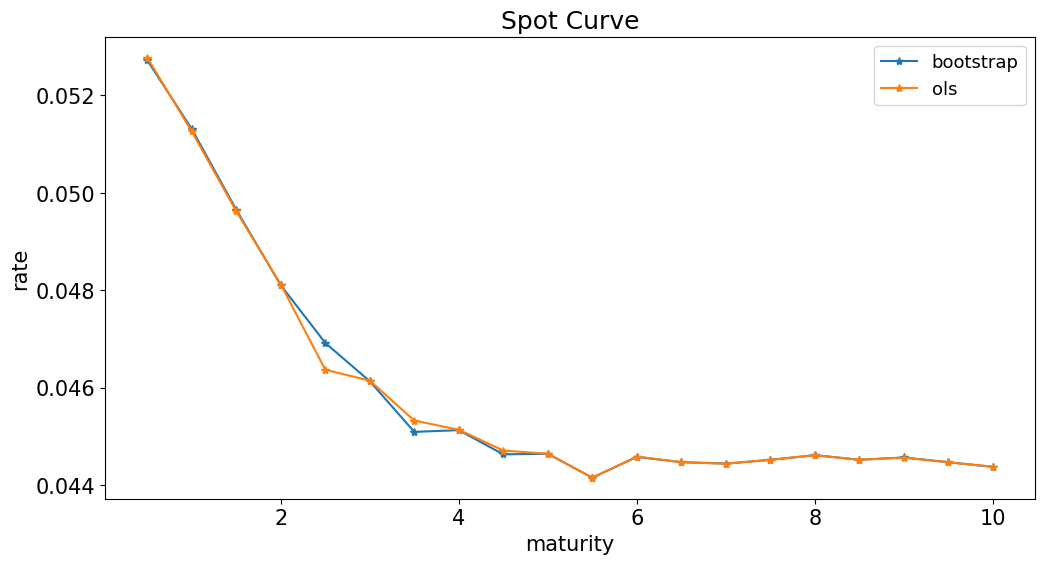

In [8]:
inc = .5
maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)

curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['bootstrap'] = interpolate_piecewise(params=params_boot,
                                                maturity=maturity_grid)
curves_ols['ols'] = interpolate_piecewise(params=params_OLS,
                                          maturity=maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity',title='Spot Curve')
plt.show()

We see the estimated spot curves are nearly identical.
- When use OLS, we use more issues (more data) and get a little different.

## Why not bootstrap the entire curve?

We have quotes with maturities out to nearly 30 years.

We restricted the bootstrap and OLS estimates to a sample 
* with at least one treasury maturing
* (and for the bootstrap) exactly one treasury maturing

**Why not include all the sample data for the bootstrap or OLS estimates?**

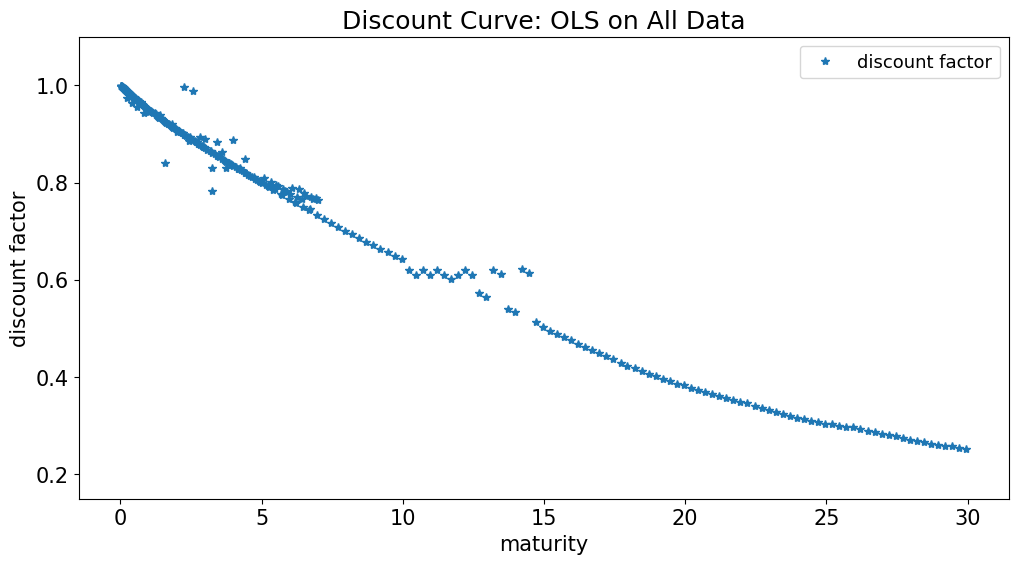

In [9]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False # For OLS

model_name = 'ols'

filtered_treasuries = filter_treasuries(data=rawdata,
                         date_curr=date_curr,
                         filter_yld = RESTRICT_YLD,
                         filter_tips = RESTRICT_TIPS,
                         drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_treasury_cashflows(quote_data=filtered_treasuries),
                               filter_maturity_dates=RESTRICT_DTS_MATURING)
CFset['all dates'] = CF

prices = treasuries['price'][CF.index]

params_OLS_bad = estimate_rate_curve(model_name=model_name,
                                  cf=CF,
                                  prices=prices,
                                  date_curr=date_curr)


disc_ols_bad = pd.DataFrame({'maturity':params_OLS_bad[0], 'discount factor': params_OLS_bad[1]}).set_index('maturity')
disc_ols_bad.plot(marker='*',linestyle='',ylim=(.15,1.1),ylabel='discount factor',title='Discount Curve: OLS on All Data')
plt.show()

Notice that the OLS-extracted discount curve...
1. vacillates extremely in the first 5 years
2. is seemingly missing discounts between 10-15 years.

These two problems are exactly what we expect when OLS is
* overfit (in the short part of the curve, due to the large amount of issues)
* unidentified due to multicolinearity (linear dependence)

**In fact, it is worse than it appears in the plot above,**
* the missing values in years 10-15 are not missing.
* rather, they are huge positive and negative values
* these values offset and keep the pricing correct

See the plot below.

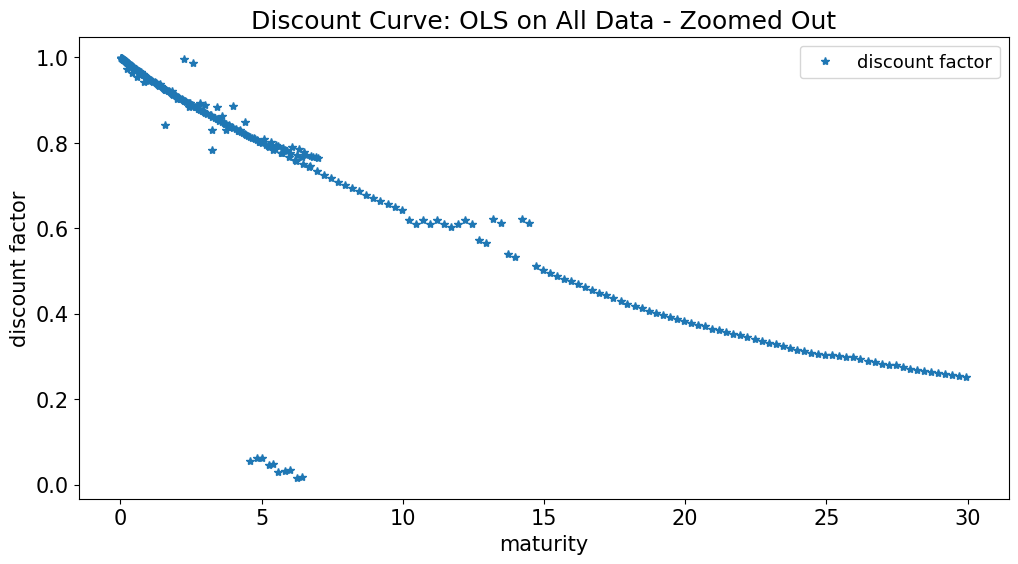

In [10]:
disc_ols_bad.plot(marker='*',linestyle='',ylabel='discount factor',title='Discount Curve: OLS on All Data - Zoomed Out')
plt.show()

Cannot use OLS with more than 10 years because of that gap of maturing securities. However, as that gap approaches the 10 year mark, it will close because the government will then issue new securities with 10 year maturity, closing that gap.

### Multicolinearity

The problem with using the Bootstrap (or more generally OLS), is **multicolinearity** in the cashflow matrix.

* Recall that perfect (mathematical) multicolinearity implies that the parameters of the system are underidentified. It is impossible to identify them from the data provided.

* Having multiple treasuries with coupons on dates without any treasury maturing means that it is impossible to identify the relative value of these coupons.

Consider the **condition number** of the cashflow matrix.
* The condition number gives an idea of how a small perturbation to the data would impact the parameter estimate.
* Well-conditioned matrices, (condition numbers below 10) lead to accurate estimation.
* Multicolinear systems have huge condition numbers, as any perturbation to the data leads to huge changes in the estimates.

Note that the condition number is closely related to the determinant.

In [11]:
condnum = dict()
for key in CFset:
    condnum[key] = np.linalg.cond(CFset[key].T @ CFset[key])

condition_numbers = pd.DataFrame({"data set":condnum.keys(), 'cashflow matrix condition number':condnum.values()}).set_index('data set').iloc[[1,2,3,0],:]
display(condition_numbers.style.format('{:.2e}'))

,cashflow matrix condition number
data set,
"single maturity per date, no non-maturity dates",1.53e+00
no non-maturity dates,4.18e+00
all dates,1.09e+18
"all dates, including negative YTM quotes",3.08e+17


Massive condition number indicates multicollinearity.

# Nelson Siegel Model of the Yield Curve

We need a model for the curve to avoid...
* missing data
* overfitting in-sample

The most famous such model is the **Nelson-Siegel** model.

It models the spot curve according to 
* maturity
* 6 parameters


Let
* $\tau$ denote the maturity interval, $\tau=T-t$:
* $\boldsymbol{\theta}$ denote the vector of parameters to be estimated. (Here, 4 parameters: $\theta_0, \theta_1, \theta_2, \lambda$)

$\begin{align}
r(t,T) =& f(T-t,\boldsymbol{\theta})\\
=& \theta_0 + (\theta_1 + \theta_2)\frac{1-e^{-T/\lambda}}{T/\lambda} - \theta_2 e^{-T/\lambda}
\end{align}
$

What we are doing:
- Pick some parameters arbitrarily and use those in the Nelson-Siegel formula to create discount rates. 
- Once we have that curve, we change those to discount factors, compare to market prices and take the sum of squared errors.
- Then we do the entire process again and check if we get a better score.

However, if you start with some weird initial conditions, you will get some bad results (not so robust as OLS).
If you are getting trouble to get convergence, make sure you are using values that make sense as initial conditions.


Note that for any set of parameters, we have...

| spot curve                  | $r_{\text{NS}}(t,T;\boldsymbol{\theta})$                                      |   |   |   |
|-----------------------------|-------------------------------------------------------------------------------|---|---|---|
| discount factors            | $Z_{\text{NS}}(t,T;\boldsymbol{\theta})$                                      |   |   |   |
| modeled bond prices         | $P_{\text{NS}}(t,T;\boldsymbol{\theta})$                                      |   |   |   |
| sum of squared model errors | $\left(P_{\text{mkt}}(t,T) - P_{\text{NS}}(t,T;\boldsymbol{\theta})\right)^2$ |   |   |   |


The Nelson-Siegel model is estimated by searching across the parameter space to minimize this sum of squared errors.

The **parameter table** below shows these optimized choices.

It shows this for Nelson-Siegel, as well as for an extended, 6-parameter, version of the model.

In [12]:
prices = treasuries['price'][CF.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    x0 = np.ones(4)/10
    params_NS = estimate_rate_curve(model_name='nelson_siegel',
                                    cf=CF,
                                    prices=prices,
                                    date_curr=date_curr,
                                    x0=x0)

    x0 = np.concatenate((params_NS,(1/10,1/10)))
    params_NSE = estimate_rate_curve(model_name='nelson_siegel_extended',
                                    cf=CF,
                                    prices=prices,
                                    date_curr=date_curr,
                                    x0=x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
tab_params_ns

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.048764,0.007844,-0.025257,2.344197,None,None
Nelson-Siegel Extended,0.049480,-0.000087,-0.020947,2.339517,0.053273,0.076244


### Use these fitted paramaters to calculate the Spot Curve

Note that the parameterized functional form allows us to model the curve 
* for any maturity.
* in a smooth way that avoids recommending extreme long-short positions

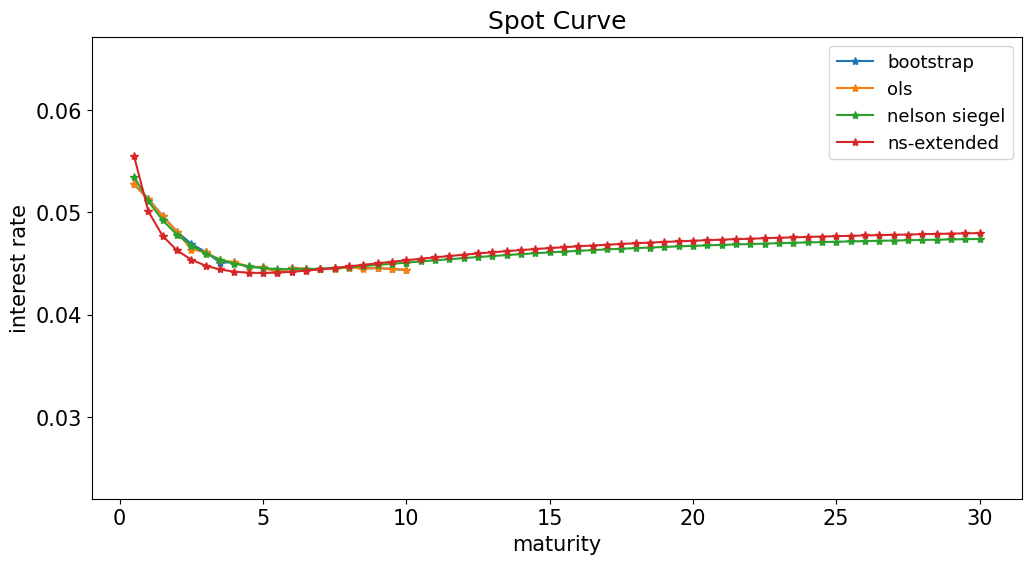

In [13]:
inc = .5

maturity_list = get_maturity_delta(t_maturity=list(CFset.values())[-1].columns, date_curr=date_curr)
maturity_grid = np.arange(inc,maturity_list.max()+.5,inc)

curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params=params_NS,maturity=maturity_grid)
curves['ns-extended']= nelson_siegel_extended(params=params_NSE,maturity=maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(.5*curves.min().min(),1.1*curves.max().max()*1.1))

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()

### Convert the spot curve to the discount curve

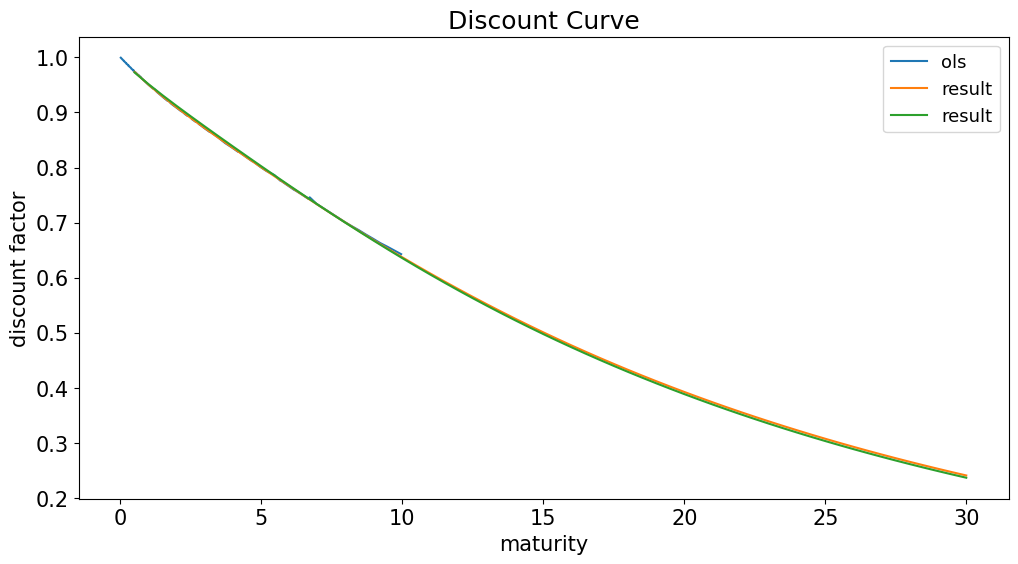

In [14]:
ax = disc_ols.plot()

zero_curve_ns = convert_rate_to_discount(rate_or_discount=curves.loc[:,'nelson siegel'],
                                      time_to_maturity=maturity_grid,
                                      n_compound=None)

zero_curve_nse = convert_rate_to_discount(rate_or_discount=curves.loc[:,'ns-extended'],
                                      time_to_maturity=maturity_grid,
                                      n_compound=None)
zero_curve = pd.concat([zero_curve_ns,zero_curve_nse],axis=1)
zero_curve.plot(ax=ax, title='Discount Curve', xlabel='maturity',ylabel='discount factor')

plt.show()

# Spot Curves vs YTM

Note that we immediately calculate the YTM for each issue.

If we plot these YTM against maturity, we get a curve.

**This YTM curve is not the same as the spot curve, (often referred to as the yield curve, confusingly.)**

The YTM is a certain average of semi-compounded spot rates over the range of the issue's maturity.

For that reason, we should not be surprised to see the YTM plot is slightly below the spot curve for most of the range.

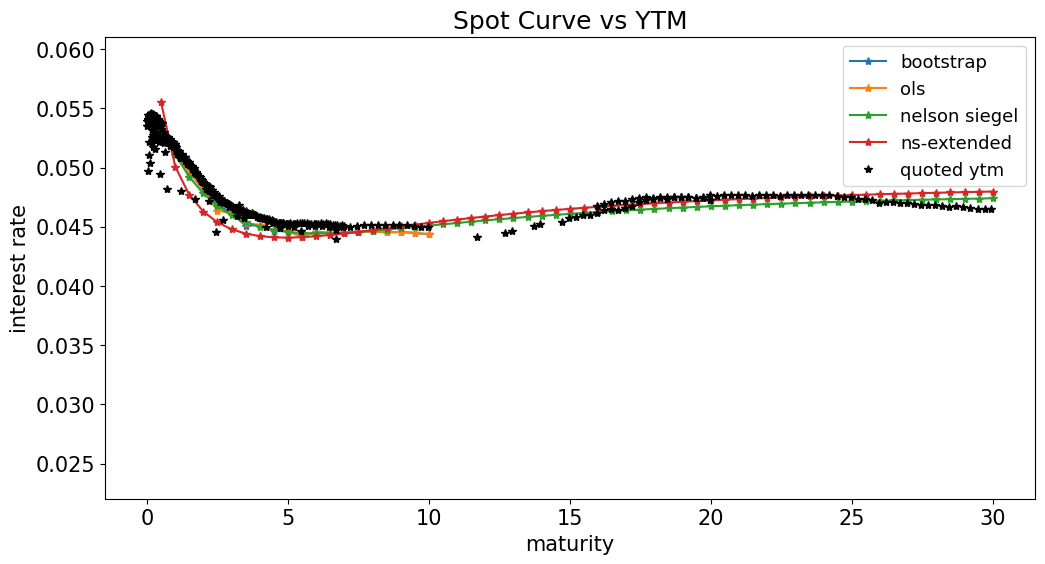

In [15]:
ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(.5*curves.min().min(),curves.max().max()*1.1))
treasuries.set_index('ttm')['ytm'].plot(ax=ax, linestyle='',marker='*', color='k')

series_plotted = list(curves_ols.columns) + list(curves.columns) + ['quoted ytm']
plt.legend(series_plotted)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve vs YTM')
plt.show()

# Model Prices and Errors

How well does the Nelson-Siegel model fit market prices?

How well did the bootstrap and OLS do?

Compare by looking at the sum of squared areas of
* model prices vs market prices
* across various subsamples

In [19]:
def compare_pricing(CF):

    price_comp = pd.DataFrame(columns=['ttm','quoted','bootstrap','ols','nelson siegel','ns-extended'], index=rawdata.index)
    price_comp['ttm'] = treasuries['ttm'][CF.index]
    price_comp['quoted'] = treasuries['price'][CF.index]
    price_comp['bootstrap'] = price_with_rate_model(params=params_boot,cf=CF,date_curr=date_curr,model_name='bootstrap')
    price_comp['ols'] = price_with_rate_model(params=params_OLS,cf=CF,date_curr=date_curr,model_name='OLS')
    price_comp['nelson siegel'] = price_with_rate_model(params=params_NS,cf=CF,date_curr=date_curr,model_name='nelson_siegel')
    price_comp['ns-extended'] = price_with_rate_model(params=params_NSE,cf=CF,date_curr=date_curr,model_name='nelson_siegel_extended')
    price_comp.set_index('ttm',inplace=True)

    errors = (price_comp.sub(price_comp['quoted'],axis=0)**2).sum(axis=0)

    return price_comp, errors

In [26]:
errors = pd.DataFrame()

keys = list(CFset.keys())
keys.append(keys[0])
keys.pop(0)
price_comps = {}
for key in keys:
    price_comps[key], errors[key] = compare_pricing(CFset[key])

sample = {k: v.shape[0] for k, v in CFset.items()}
display(pd.DataFrame(sample, index=['observations'])[errors.columns])

errors.style.format('{:.2f}')


,"single maturity per date, no non-maturity dates",no non-maturity dates,all dates,"all dates, including negative YTM quotes"
observations,125,193,393,446


,"single maturity per date, no non-maturity dates",no non-maturity dates,all dates,"all dates, including negative YTM quotes"
quoted,0.00,0.00,0.00,0.00
bootstrap,0.00,1.92,2240.35,13747.56
ols,0.35,0.99,1485.32,13665.35
nelson siegel,1.84,2.82,45.40,15309.03
ns-extended,6.12,10.32,79.40,15633.25


In [29]:
def plot_prices(price_comp,label):
    
    marker_list = ['o', '^', 'v', 'x', '+']
    color_list = ['k', 'b', 'm', 'r', 'g']

    plt.figure()
    ax = plt.gca()

    for i, col in enumerate(price_comp.columns):
        ax.scatter(x=price_comp.index, y=price_comp[col], marker=marker_list[i], color=color_list[i])
    
    plt.xlabel('maturity')
    plt.ylabel('price')
    plt.legend(price_comp.columns)
    plt.title(f'Price Comparison ({label})')
    plt.show()    

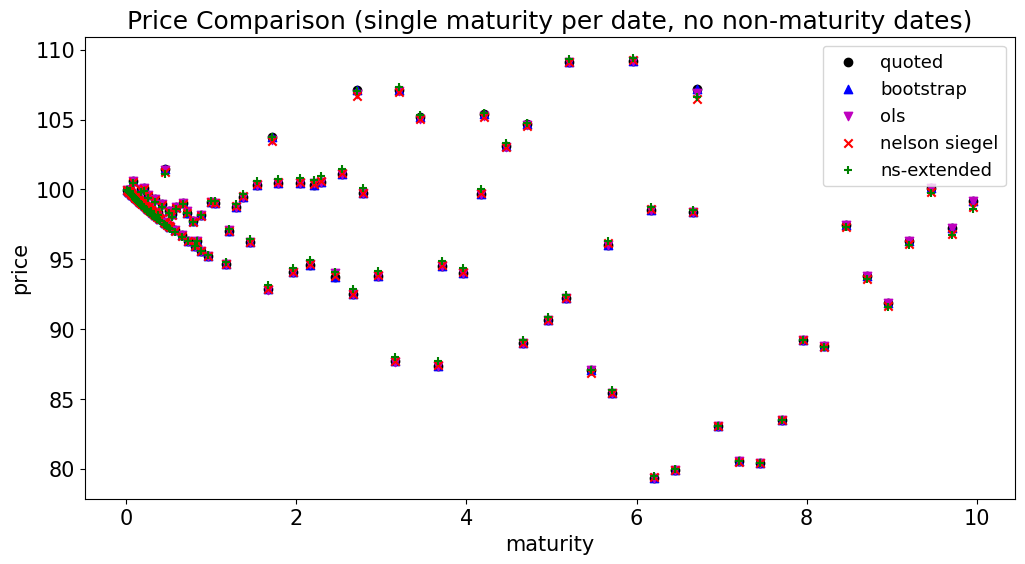

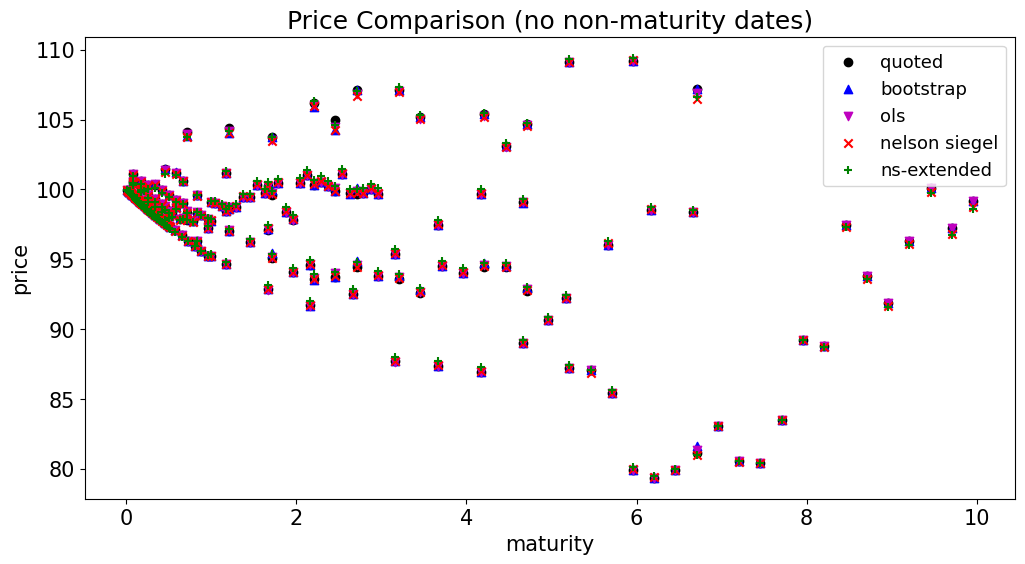

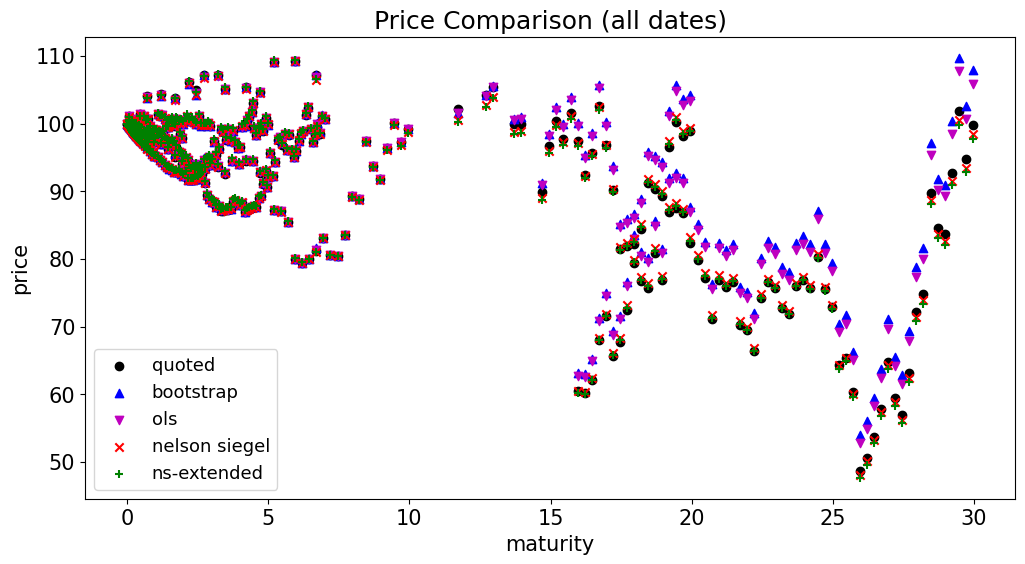

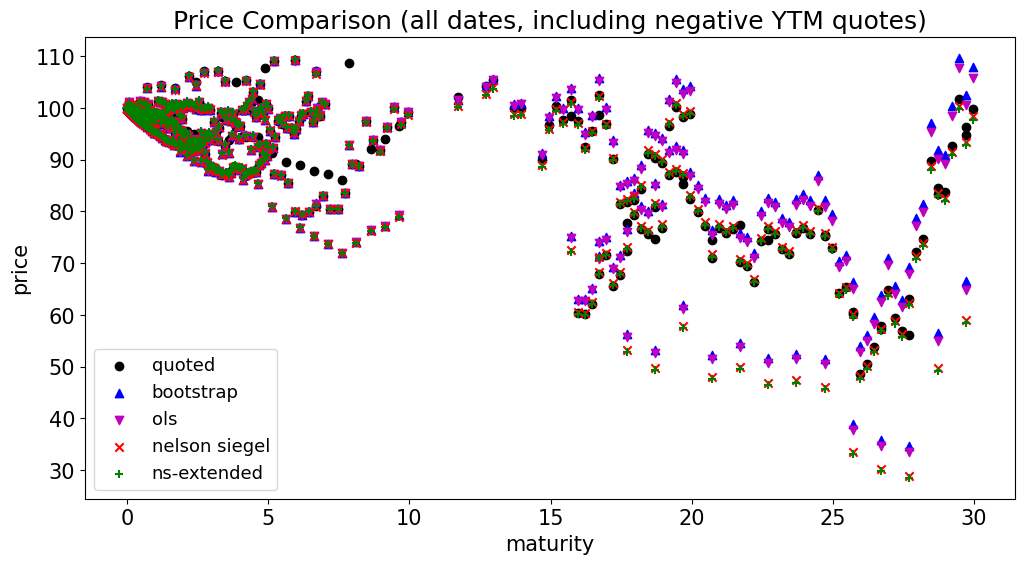

In [31]:
for key in keys:
    plot_prices(price_comps[key],key)

***